# Convolutional Neural Net for Image Recognition

In [28]:
 !pip install keras

In [29]:
# IPython display functions
import IPython
from IPython.display import display, HTML, SVG, Image

# General Plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

## notebook style and settings
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))

# For changing background color
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

# Library Imports

In [30]:
import os
import sys
import random
import numpy as np
import pandas as pd
from os import walk

# Metrics
from sklearn.metrics import *

# Keras library for deep learning
# https://keras.io/
import tensorflow as tf
import keras
from keras.datasets import mnist # MNIST Data set
from keras.models import Sequential # Model building
from keras.layers import * # Model layers
from keras.preprocessing.image import *
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Helper Functions

## 1.1 Confusion Matrix
Confusion matrices are an important toolkit in every data scientist's box

In [31]:
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    # Set font size for the plots
    PLOT_FONT_SIZE = 14
    
    # Set plot size
    plt.rcParams['figure.figsize'] = [5, 5]
    
    # Transpose of confusion matrix to align the plot with the actual precision recall values
    confusionMatrix = np.transpose(confusionMatrix)
    
    # Plotting the confusion matrix
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    
    
    # Setting plot properties
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Healthy\nRecall=" + str(recallNegative) , "Pneumonia\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Healthy\nPrecision=" + str(precisionNegative) , "Pneumonia\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
        
    # Add text in heatmap boxes
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap
            
    plt.show()

## 1.2 Metrics Calculation
A function that will calculate all the metrics needed in order to analyze the model

In [32]:
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    # Convert label format from [0,1](label 1) and [1,0](label 0) into single integers: 1 and 0.
    actualLabels = [item[1] for item in actualLabels]
    
    # Get probabilities for the class with label 1. That is all that is need to compute AUCs. Don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    
    # Print metrics. .%2f prints a number upto 2 decimal points only.
    print("------------------------------------------------------------------------")
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    print("------------------------------------------------------------------------")
    
    print("+ Printing confusion matrix...\n")
    # Display confusion matrix
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    
    print("+ Printing ROC curve...\n")
    # ROC Curve
    plt.rcParams['figure.figsize'] = [16, 8]
    FONT_SIZE = 16
    falsePositiveRateDt, truePositiveRateDt, _ = roc_curve(actualLabels, predictionsProbabilities)
    plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 5, color='black')
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
    plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
    plt.show()
    
    return auc

## 1.3 Kaggle Predictions

In [33]:
def getKagglePredictions(model, kaggleData, filename):
    print("+ Writing kaggle test results in : results/%s..." % filename)
    predictions = model.predict(kaggleData)
    predictionProbs = [item[1] for item in predictions]
        
    # Store predictions for kaggle
    outputFile = open("results/" + str(filename), "w")
    outputFile.write("Id,Prediction\n")
    for i in range(0, len(predictionProbs)):
        outputFile.write(str(i + 1) + "," + str(predictionProbs[i]) + "\n")
    
    outputFile.close()

## 1.4 Top n% accuracy

In [34]:
def calculateClasswiseTopNAccuracy(actualLabels, predictionsProbs, TOP_N):
    """
    TOP_N is the top n% predictions to use for each class
    """

    discreteActualLabels = [1 if item[1] > item[0] else 0 for item in actualLabels]
    discretePredictions = [1 if item[1] > item[0] else 0 for item in predictionsProbs]
    predictionProbsTopNHealthy, predictionProbsTopNPneumonia = [item[0] for item in predictionsProbs], [item[1] for item in predictionsProbs]
    predictionProbsTopNHealthy = list(reversed(sorted(predictionProbsTopNHealthy)))[:int(len(predictionProbsTopNHealthy) * TOP_N / 100)][-1]
    predictionProbsTopNPneumonia = list(reversed(sorted(predictionProbsTopNPneumonia)))[:int(len(predictionProbsTopNPneumonia) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyHealthy = []
    accuracyPneumonia = []
    for i in range(0, len(discretePredictions)):
        if discretePredictions[i] == 1:
            # Pneumonia
            if predictionsProbs[i][1] > predictionProbsTopNPneumonia:
                accuracyPneumonia.append(int(discreteActualLabels[i]) == 1)
        else:
            # Healthy
            if predictionsProbs[i][0] > predictionProbsTopNHealthy:
                accuracyHealthy.append(int(discreteActualLabels[i]) == 0)

    accuracyHealthy = round((accuracyHealthy.count(True) * 100) / len(accuracyHealthy), 2)
    accuracyPneumonia = round((accuracyPneumonia.count(True) * 100) / len(accuracyPneumonia), 2)
    return accuracyHealthy, accuracyPneumonia

# 2. Data Loading
## 2.1 Loading File Paths
Loading file paths from normal and pneumonia folders in the train directory.

In [35]:
# Load normal images
normalImagesPath = "data/train/normal"
normalImageFiles = []
for(_,_,files) in walk(normalImagesPath):
    normalImageFiles.extend(files)


# Load pneumonia images
pneumoniaImagesPath = "data/train/pneumonia"
pneumoniaImageFiles = []
for(_,_,files) in walk(pneumoniaImagesPath):
    pneumoniaImageFiles.extend(files)
    
random.shuffle(pneumoniaImageFiles)
pneumoniaImageFiles = pneumoniaImageFiles[:len(normalImageFiles)]
print("Normal X-ray images: %d\nPneumonia X-ray images: %d" % (len(normalImageFiles), len(pneumoniaImageFiles)))

Normal X-ray images: 1436
Pneumonia X-ray images: 1436


## 2.2 Loading Image Data
### 2.2.1 Training and Validation

In [36]:
imagesData = []
imagesLabels = []

for file in normalImageFiles:
    fullPath = normalImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
            continue
    imageData = load_img(normalImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library using "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(0)
    

for file in pneumoniaImageFiles:
    fullPath = pneumoniaImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
            continue
            
    imageData = load_img(pneumoniaImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library using "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    imagesData.append(imageArray)
    imagesLabels.append(1)

imagesData = np.array(imagesData)
imagesLabels = keras.utils.to_categorical(imagesLabels)
print("Input data shape: %s" % (imagesData.shape,))

Input data shape: (2872, 256, 256, 1)


### 2.2.2 Kaggle Testing Data

In [37]:
testImagesPath = "data/test/"
testImageFiles = []
for(_,_,files) in walk(testImagesPath):
    testImageFiles.extend(files)
testImageFiles = list(sorted(testImageFiles))
    
kaggleTestImages = []
for file in testImageFiles:
    fullPath = testImagesPath + "/" + file
    if os.path.exists(fullPath) == False:
        continue
    imageData = load_img(testImagesPath + "/" + file, color_mode = "grayscale") # load_img function comes from keras library when we do "from keras.preprocessing.image import *"
    imageArray = img_to_array(imageData) / 255.0
    
    kaggleTestImages.append(imageArray)
    
kaggleTestImages = np.array(kaggleTestImages)
print("Number of test images: %d" % len(kaggleTestImages))

Number of test images: 200


## 2.3 Data Splitting into Training and Validation

In [38]:
def trainTestSplit(data, labels):
    """
    80-20 train-test data split
    """
    trainData, trainLabels, testData, testLabels = [], [], [], []
    for i in range(0, len(data)):
        if i % 5 == 0:
            testData.append(data[i])
            testLabels.append(labels[i])
        else:
            trainData.append(data[i])
            trainLabels.append(labels[i])
            
    return np.array(trainData), np.array(testData), np.array(trainLabels), np.array(testLabels)

In [39]:
# In this context, since this was meant to be tested on a private kaggle competition, the test data here would actually mean validation data. Will use results on this validation(test) data to see how the model would perform on the actual test data.
# Split data into 80% training and 20% testing
trainData, testData, trainLabels, testLabels = trainTestSplit(imagesData, imagesLabels)

# 3. Deep Learning Models
I will use keras to create deep learning models. For more details, please visit: https://keras.io/layers/convolutional/


## 3.1 Parameterized Convolutional Neural Networks
Created a simple function that takes in a few parameters and creates a convolutional neural network model. Easiest way to replicate a CNN model.

In [40]:
def createParameterizedConvolutionalNeuralNetwork(trainImages, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses):
    # Create model object
    model = Sequential()
    
    # Add the first layer with dropout
    model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                       activation='relu', padding = 'same',
                     input_shape=trainImages.shape[1:]))
    model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
    model.add(Dropout(dropoutValue))
    
    while numLayers > 1:
        model.add(Conv2D(numFilters, kernel_size=(kernelSize, kernelSize),
                     activation='relu', padding = 'same'))
        model.add(MaxPooling2D(pool_size=(maxPooling, maxPooling)))
        model.add(Dropout(dropoutValue))
        
        numLayers = numLayers - 1
        
    # Convolutional layers are done, adding the remaining stuff. After Conv layers, you should always use a Flatten() layer.
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropoutValue))
    model.add(Dense(numClasses, activation='softmax'))

    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=learningRate),
                  metrics=['accuracy'])
    
    # Return model
    return model

## 3.2 More Nuanced Convolutional Neural Networks
In this section, I created a more nuanced model to comprae to the parameterized model.

In [41]:
def createNuancedConvolutionalNeuralNetwork(trainImages, numClasses):
        # Create model object
    model = Sequential()
    
    model.add(Conv2D(filters = 8, kernel_size=(3, 3),
                     activation='relu', padding = 'same',
                     input_shape=trainImages.shape[1:]))
    
    model.add(Conv2D(filters = 8, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    
    model.add(Conv2D(filters = 16, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    
    model.add(Conv2D(filters = 16, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Conv2D(filters = 32, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(Conv2D(filters = 32, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(Conv2D(filters = 32, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Conv2D(filters = 64, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(Conv2D(filters = 64, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(Conv2D(filters = 64, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Conv2D(filters = 64, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(Conv2D(filters = 64, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(Conv2D(filters = 64, kernel_size=(3, 3),
                     activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    # Convolutional layers are done, adding the remaining stuff. Reminder to add a Flatten() layer after the Convolutional layers.
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(numClasses, activation='softmax'))

    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])
    
    # Return model
    return model

# 4. Model Training
## 4.1 Data Augmentation
Deep learning models require huge amounts of data for good performance. With only around 5k examples, I will use what's called "Data Augmentation" to create more data. To read more on data augmentation, more info here: https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9

In [42]:
set_background('#fce53a')
#Parameters here will give vastly different model performance results. For more info:
# https://keras.io/preprocessing/image/
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
dataAugmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.3,
    zoom_range=0.2)

## 4.2 Model Parameters

In [43]:
set_background('#fce53a')

#####################################################################################################################################################
# Model Parameters for Parameterized and Nuanced Models - Some parameters are only for Parameterized Model                                                                                                           
#####################################################################################################################################################
numLayers = 2 # Number of layers in the neural network
numFilters = 32 # Number of units in each layer
kernelSize = 5 # filter size of a single filter
dropoutValue = 0.4 # Dropout probability
maxPooling = 2 # Max pooling
numClasses = 2 # For MNIST since there are 10 classes i.e The model is trying to recognize a digit among 10 digits. For any other data set, this should be changed
batchSize = 16 # How many images should a single batch contain
learningRate = 0.0001 # How fast should the model learn
epochs = 20 # Number of epochs to train the model for
USE_DATA_AUGMENTATION = True # You can set it to false if you do not want to use data augmentation. We recommend trying both true and false.
#####################################################################################################################################################


# Training the augmentor in case we set USE_DATA_AUGMENTATION to True. This line needs to be here if data augmentation is enabled
dataAugmentation.fit(trainData) 

## 4.3 Training and Validation

### 4.3.1 Model Instantiation

In [44]:
# Create model
parameterizedModel = createParameterizedConvolutionalNeuralNetwork(trainData, numLayers, numFilters, kernelSize, maxPooling, dropoutValue, learningRate, numClasses = 2)
print("+ Your parameterized model has been created...")

+ Your parameterized model has been created...


In [45]:
# You can create the other model with the following line
nonParameterizedModel = createNuancedConvolutionalNeuralNetwork(imagesData, numClasses = 2)
print("+ Your non parameterized model has been created...")

+ Your non parameterized model has been created...


In [46]:
#####################################################################################################################################################
# Choose Parameterized or Non Parameterized - Nuanced Model                                                                                                         
#####################################################################################################################################################

# Please assign model the deep learning model you want to use i.e parameterizedModel or nonParameterizedModel
model = nonParameterizedModel

In [47]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 256, 256, 8)       80        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 32)       

### 4.3.2 Model Training and Validation

In [ ]:
bestAcc = 0.0
bestEpoch = 0
bestAccPredictions, bestAccPredictionProbabilities = [], []

print("+ Starting training. Each epoch can take about 2-5 minutes, hold tight!")
print("-----------------------------------------------------------------------\n")
for epoch in range(epochs):
    
    #################################################### Model Training ###############################################################
    if USE_DATA_AUGMENTATION == True:
        # Use data augmentation in alternate epochs
        if epoch % 2 == 0:
            ############ Can change the "epoch % 2" to some other integer value to train on top of the augmented data 
            ############ after a certain number of epochs e.g "epoch % 3" will train on augmented data after every 2 epochs ############
            model.fit_generator(dataAugmentation.flow(trainData, trainLabels, batch_size=batchSize),
                        steps_per_epoch=len(trainData) / batchSize, epochs=1, verbose = 2)
        else:
            model.fit(trainData, trainLabels, batch_size=batchSize, epochs=1, verbose = 2)
    else:
        # Do not use data augmentation
        model.fit(trainData, trainLabels, batch_size=batchSize, epochs=1, verbose = 2)
    
    
    #################################################### Model Testing ###############################################################
    # Calculate test accuracy
    accuracy = round(model.evaluate(testData, testLabels)[1] * 100, 3)
    predictions = model.predict(testData)
    print("+ Test accuracy at epoch %d is: %.2f" % (epoch, accuracy))
    
    if accuracy > bestAcc:
        bestEpoch = epoch
        bestAcc = accuracy
        bestAccPredictions = [1 if item[1] > item[0] else 0 for item in predictions]
        bestAccPredictionProbabilities = predictions
        
        ##################################### Store predictions for kaggle ###########################################################
        kaggleResultsFileName = "epoch-" + str(epoch) + "-results.csv"
        getKagglePredictions(model, kaggleTestImages, kaggleResultsFileName)
        ##############################################################################################################################
    print('\n')
print("------------------------------------------------------------------------")


##################################################### Printing best metrics ##########################################################
print("\n*** Printing our best validation results that we obtained in epoch %d ..." % bestEpoch)
calculateMetricsAndPrint(bestAccPredictions, bestAccPredictionProbabilities, testLabels)

+ Starting training. Each epoch can take about 2-5 minutes, hold tight!
-----------------------------------------------------------------------

Epoch 1/1
 - 121s - loss: 0.2919 - accuracy: 0.8946
575/575 [==============================] - 6s 10ms/step
+ Test accuracy at epoch 0 is: 93.04
+ Writing kaggle test results in : results/epoch-0-results.csv...


Epoch 1/1
 - 114s - loss: 0.0835 - accuracy: 0.9669
575/575 [==============================] - 6s 10ms/step
+ Test accuracy at epoch 1 is: 93.74
+ Writing kaggle test results in : results/epoch-1-results.csv...


Epoch 1/1
 - 119s - loss: 0.2932 - accuracy: 0.8886
575/575 [==============================] - 6s 10ms/step
+ Test accuracy at epoch 2 is: 91.83


Epoch 1/1
 - 111s - loss: 0.0796 - accuracy: 0.9695
575/575 [==============================] - 5s 9ms/step
+ Test accuracy at epoch 3 is: 94.96
+ Writing kaggle test results in : results/epoch-3-results.csv...


Epoch 1/1
 - 121s - loss: 0.2780 - accuracy: 0.8912
575/575 [=========

## 4.4 Top n% Predictions

+ Accuracy for top 5 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 10 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 20 percent predictions for healthy: 100.00, pneumonia: 100.00
+ Accuracy for top 30 percent predictions for healthy: 100.00, pneumonia: 100.00


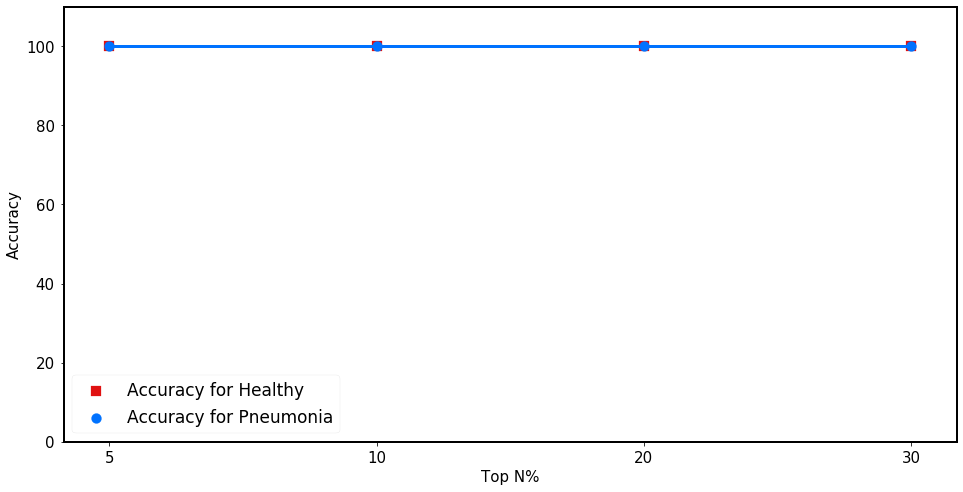

In [49]:
################################## Top n% Predictions ###########################
topNValues = [5, 10, 20, 30]
##############################################################################################################

accuraciesHealthy, accuraciesPneumonia = [], []
for topn in topNValues:
    accuracyHealthy, accuracyPneumonia = calculateClasswiseTopNAccuracy(testLabels, bestAccPredictionProbabilities, topn)
    accuraciesHealthy.append(accuracyHealthy)
    accuraciesPneumonia.append(accuracyPneumonia)
    
    print("+ Accuracy for top %d percent predictions for healthy: %.2f, pneumonia: %.2f" % (topn, accuracyHealthy, accuracyPneumonia))
    
# Plot results
x = np.arange(len(accuraciesHealthy))
plt.plot(x, accuraciesHealthy, linewidth = 3, color = '#e01111')
scatterHealthy = plt.scatter(x, accuraciesHealthy, marker = 's', s = 100, color = '#e01111')
plt.plot(x, accuraciesPneumonia, linewidth = 3, color = '#0072ff')
scatterPneumonia = plt.scatter(x, accuraciesPneumonia, marker = 'o', s = 100, color = '#0072ff')
plt.xticks(x, topNValues, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Top N%", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend([scatterHealthy, scatterPneumonia], ["Accuracy for Healthy", "Accuracy for Pneumonia"], fontsize = 17)
plt.ylim(0, 110)
plt.show()


In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 256, 256, 8)       80        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 32)       